### Authors: </br>
Ruy Guzmán </br>
Fernanda de León </br>
Karla Mondragón

# LSTM

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Dataset Overview

In [5]:
df = pd.read_csv('../database/ticker_V.csv')

In [7]:
df["Date"] = pd.to_datetime(df.Date)
df = df.set_index("Date")
df

,Open,High,Low,Close,Adj Close,Volume,Symbol
Date,,,,,,,
2021-12-06,198.770004,204.220001,197.740005,202.679993,199.573517,10722100,V
2021-12-07,206.000000,207.940002,205.889999,207.369995,204.191650,11897200,V
2021-12-08,207.660004,209.479996,205.710007,208.990005,205.786804,11749200,V
2021-12-09,208.520004,212.199997,207.169998,211.389999,208.150009,10176800,V
2021-12-10,211.899994,214.250000,210.860001,213.399994,210.129211,8882700,V
...,...,...,...,...,...,...,...
2023-11-29,253.919998,256.070007,253.520004,254.229996,254.229996,4955100,V
2023-11-30,254.250000,256.769989,253.169998,256.679993,256.679993,6874700,V
2023-12-01,255.789993,256.910004,253.899994,256.450012,256.450012,3939400,V


In [8]:
def plotVariables(df,vars, title):
    df[vars].plot(
        figsize=(15,7), 
        title=title,
        subplots = True
    )

    plt.show()

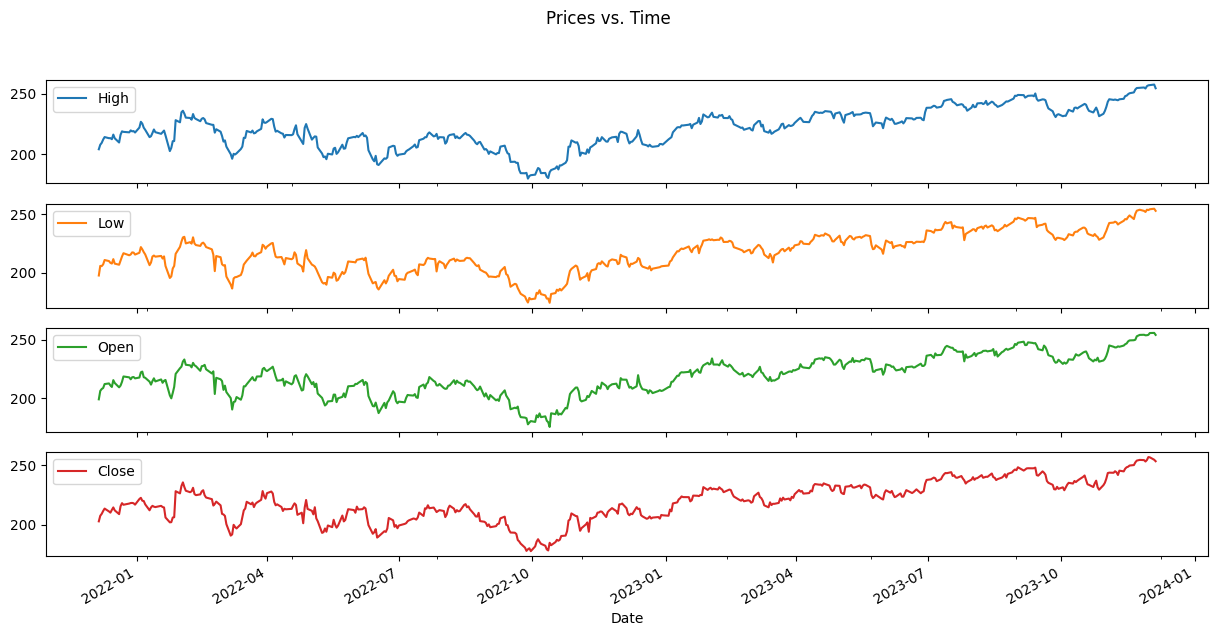

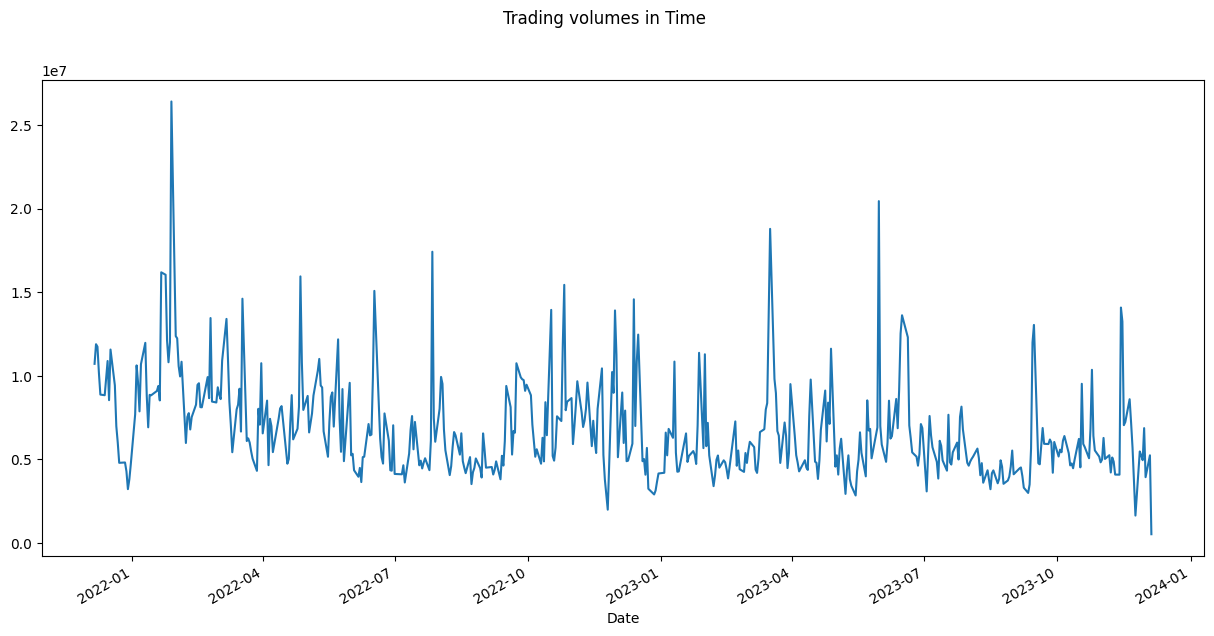

In [12]:
plotVariables(df,['High','Low','Open','Close'],'Prices vs. Time')
plotVariables(df,'Volume','Trading volumes in Time')

In [13]:
train = df.loc[df.index < '2023-04-01']
test = df.loc[df.index >= '2023-04-01']

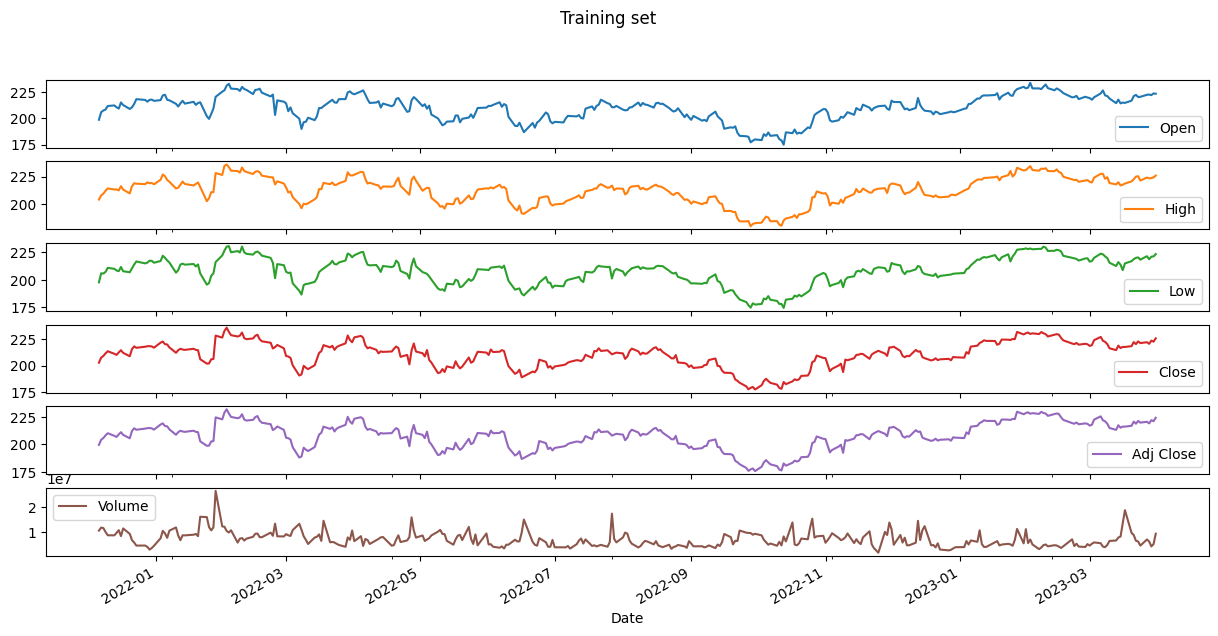

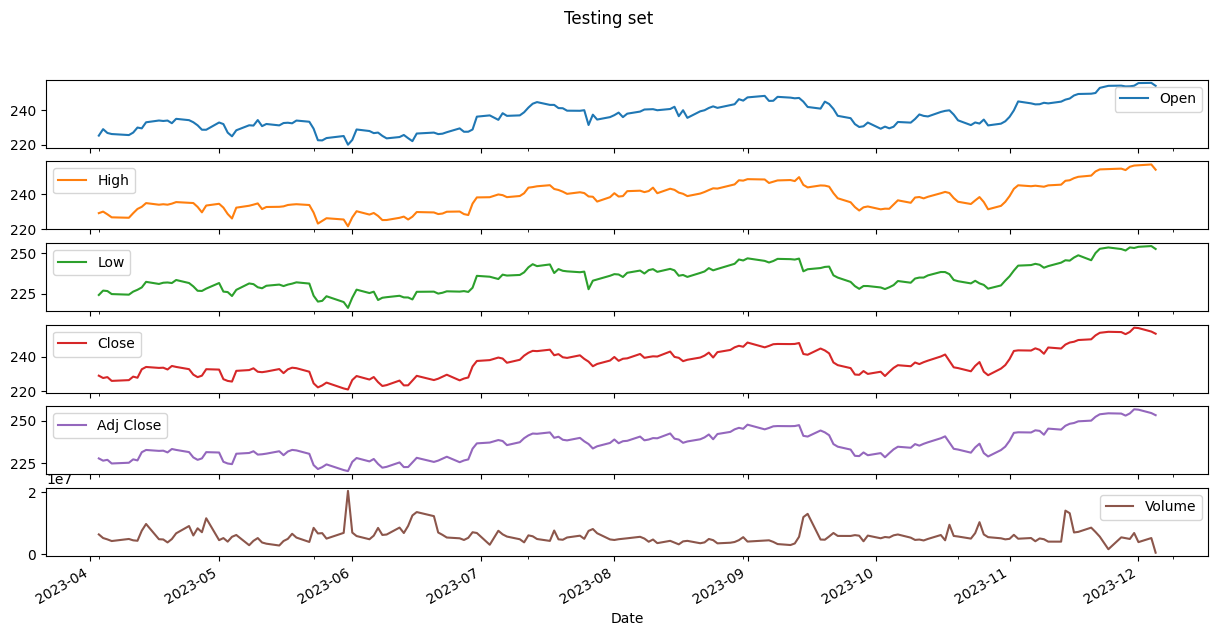

In [14]:
plotVariables(train,list(train.columns.values),'Training set')
plotVariables(test,list(test.columns.values),'Testing set')